In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
sys.path.append('../')

try:
    from premier_league import (
        constants,
        preprocessing,
        preprocessing_helpers,
        training,
        evaluation,
        prediction,
        data_extraction,
        visualisations,
        s3_helpers,
        postgres,
        mlflow_functions,
        expectations_helpers,
        email_functions,
        data_drift_functions,
    )
except ModuleNotFoundError:
    import constants
    import preprocessing
    import preprocessing_helpers
    import training
    import evaluation
    import prediction
    import data_extraction
    import visualisations
    import s3_helpers
    import postgres
    import mlflow_functions
    import expectations_helpers
    import email_functions
    import data_drift_functions

2023-12-12 09:28:43,109 - PremierLeagueLogger - INFO - Grabbing Passwords


In [2]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]

2023-12-12 09:28:46,425 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-12-12 09:28:46,937 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [3]:
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


### Set up data validation

In [4]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_class = expectations_helpers.AutoGreatExpectations(df)

In [5]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_data = ge_class.generate_expectations(verbose=False)

Generating expectations
Done


In [6]:
if constants.RUN_DATA_EXPECTATIONS:
    expectations_helpers.view_suite_summary(ge_data)

2023-12-12 09:28:47,268 - PremierLeagueLogger - INFO - Total Expectations: 18
2023-12-12 09:28:47,455 - PremierLeagueLogger - INFO - Counts:
2023-12-12 09:28:47,694 - PremierLeagueLogger - INFO - expect_column_values_to_be_of_type: 7
2023-12-12 09:28:47,890 - PremierLeagueLogger - INFO - expect_column_values_to_be_of_type: 7
2023-12-12 09:28:48,097 - PremierLeagueLogger - INFO - expect_column_values_to_be_in_set: 1
2023-12-12 09:28:48,324 - PremierLeagueLogger - INFO - expect_column_values_to_be_in_set: 1
2023-12-12 09:28:48,526 - PremierLeagueLogger - INFO - expect_table_columns_to_match_set: 1
2023-12-12 09:28:48,755 - PremierLeagueLogger - INFO - expect_table_columns_to_match_set: 1
2023-12-12 09:28:48,975 - PremierLeagueLogger - INFO - expect_column_values_to_be_between: 2
2023-12-12 09:28:49,195 - PremierLeagueLogger - INFO - expect_column_values_to_be_between: 2
2023-12-12 09:28:49,415 - PremierLeagueLogger - INFO - expect_column_values_to_be_null: 7
2023-12-12 09:28:49,612 - Pre

In [7]:
# Save expectations to S3
expectations_helpers.save_expectations(
    ge_data,
    f'app_data/expectations/exp_prem_results_{constants.current_time}.json'
)

2023-12-12 09:28:49,882 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/exp_prem_results_20231212.json
2023-12-12 09:28:50,390 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/exp_prem_results_20231212.json


### Validate data

In [8]:
# Load latest expectations
data_expectations = expectations_helpers.load_latest_expectations(
    expectations_helpers.latest_exp_file()
)

2023-12-12 09:28:50,915 - PremierLeagueLogger - INFO - Looking for latest expectations file
2023-12-12 09:28:51,231 - PremierLeagueLogger - INFO - Loading expectations from premier-league-app/app_data/expectations/exp_prem_results_20231212.json
2023-12-12 09:28:51,533 - PremierLeagueLogger - INFO - Loaded expectations from premier-league-app/app_data/expectations/exp_prem_results_20231212.json


In [9]:
if constants.INITIAL_DATA_LOAD:
    full_data = data_extraction.load_all_data(
        constants.TRAINING_DATA_LOCATION,
        constants.COLUMNS_REQ
    )
else:
    full_data = s3_helpers.grab_data_s3(
        constants.TRAINING_DATA_LOCATION
    )


2023-12-12 09:28:51,883 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-12-12 09:28:52,297 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [10]:
full_data = data_extraction.add_new_data(
    full_data, 
    constants.COLUMNS_REQ,
    constants.TRAINING_DATA_LOCATION
)

2023-12-12 09:28:52,626 - PremierLeagueLogger - INFO - Trying to read data from https://www.football-data.co.uk/mmz4281/2324/E0.csv
2023-12-12 09:28:53,214 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/training_data_full.csv
2023-12-12 09:28:54,156 - PremierLeagueLogger - INFO - Data saved at app_data/training_data_full.csv


In [11]:
validation_results = expectations_helpers.validate_data(
        full_data, 
        data_expectations,
        expectations_path = constants.VALIDATION_RESULTS_PATH
)

2023-12-12 09:28:54,485 - PremierLeagueLogger - INFO - {'evaluated_expectations': 18, 'successful_expectations': 18, 'unsuccessful_expectations': 0, 'success_percent': 100.0}
2023-12-12 09:28:54,727 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/valid_results_20231212.json
2023-12-12 09:28:55,108 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/valid_results_20231212.json


In [12]:
if not validation_results['success']:
    email_functions.send_email(
        'data_validation',
        constants.S3_BUCKET, 
        expectations_helpers.latest_exp_file(),
        constants.VALIDATION_TOPIC, 
    )
    raise Exception('Stopping Pipeline. Validation has failed')

### Data Drift Detection

In [13]:
# Load historical data
historical = s3_helpers.grab_data_s3(
    constants.HISTORICAL_DATA_DRIFT
)

2023-12-12 09:28:55,457 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/historical_pl_data.csv
2023-12-12 09:28:55,881 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/historical_pl_data.csv


In [14]:
data_drift = data_drift_functions.DriftDetector(
    historical,
    full_data
)

In [15]:
drift_report = data_drift.check_data_drift(
    constants.DRIFT_REPORT_LOC
)

2023-12-12 09:28:56,739 - PremierLeagueLogger - INFO - Saving drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231212.html
INFO:PremierLeagueLogger:Saving drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231212.html
2023-12-12 09:28:58,389 - PremierLeagueLogger - INFO - Saved drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231212.html
INFO:PremierLeagueLogger:Saved drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231212.html


{'drift_share': 0.5, 'number_of_columns': 7, 'number_of_drifted_columns': 0, 'share_of_drifted_columns': 0.0, 'dataset_drift': False}


### Preprocessing

In [16]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]
df.head()

2023-12-12 09:28:58,730 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
INFO:PremierLeagueLogger:Loading data from premier-league-app/app_data/training_data_full.csv
2023-12-12 09:28:59,143 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv
INFO:PremierLeagueLogger:Successfully loaded data from premier-league-app/app_data/training_data_full.csv


,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


In [17]:
transformers = preprocessing.fit_transformers(
    df
)

2023-12-12 09:28:59,470 - PremierLeagueLogger - INFO - Fitting Transformer
INFO:PremierLeagueLogger:Fitting Transformer
2023-12-12 09:28:59,723 - PremierLeagueLogger - INFO - Fitting Transformer
INFO:PremierLeagueLogger:Fitting Transformer


In [18]:
s3_helpers.save_transformer_s3_pickle(
    transformers, 
    constants.TRANSFORMER_PATH
)

2023-12-12 09:29:25,086 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/transformers/transformer_v2_20231212.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/transformers/transformer_v2_20231212.pkl
2023-12-12 09:29:25,466 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/transformers/transformer_v2_20231212.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/transformers/transformer_v2_20231212.pkl


In [19]:
transformed_data = preprocessing.transform_data(
    df, transformers
)

2023-12-12 09:29:25,766 - PremierLeagueLogger - INFO - Transforming Data
INFO:PremierLeagueLogger:Transforming Data
2023-12-12 09:29:26,046 - PremierLeagueLogger - INFO - Transforming Data
INFO:PremierLeagueLogger:Transforming Data


In [20]:
#transformed_data = transformed_data.drop(['HomeTeam', 'AwayTeam', 'season'], axis=1)

In [21]:
training_data, testing_data = preprocessing.split_data(transformed_data)

2023-12-12 09:29:50,913 - PremierLeagueLogger - INFO - Splitting Data
INFO:PremierLeagueLogger:Splitting Data


In [22]:
training_data.shape

(8640, 33)

In [23]:
testing_data.shape

(2160, 33)

In [24]:
training_data.head(2)

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,...,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate
0,2010-11,Wigan,Tottenham,1,29.0,41.0,51.0,34.0,0.967742,1.612903,...,-0.709677,0.225806,-0.645161,0.032258,19,4,15,Saturday,April,2
1,2000-01,Man City,Arsenal,2,34.0,49.0,52.0,29.0,0.843750,1.781250,...,-0.562500,0.625000,-0.937500,-0.187500,13,3,10,Wednesday,April,11


### Model Training

In [25]:
target_column = 'FTR'

In [26]:
hyperparameters = training.optimise_hyperparameters(
    training_data,
    target_column,
    max_evals = constants.MAX_EVALS
)

2023-12-12 09:29:51,241 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-12-12 09:29:51,445 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                                                                  | 0/2 [00:00<?, ?trial/s, best loss=?]

2023-12-12 09:29:51,703 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-12 09:29:51,923 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-12 09:29:58,254 - PremierLeagueLogger - INFO - Loss: -0.53125
INFO:PremierLeagueLogger:Loss: -0.53125


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 1/2 [00:06<00:06,  6.74s/trial, best loss: -0.53125]

2023-12-12 09:29:58,445 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-12 09:29:58,637 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-12 09:29:59,329 - PremierLeagueLogger - INFO - Loss: -0.5266203703703703
INFO:PremierLeagueLogger:Loss: -0.5266203703703703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.90s/trial, best loss: -0.53125]


In [27]:
print(hyperparameters)

{'learning_rate': 0.06000000000000001, 'iterations': 300, 'max_depth': 10}


In [28]:
# Start postgresDB for model logging
if postgres.get_instance_status(
        constants.POSTGRES_DB_ID) != 'available':
    postgres.start_rds_instance(constants.POSTGRES_DB_ID)

2023-12-12 09:29:59,766 - PremierLeagueLogger - INFO - Grabbing instance status of premier-league-logging
INFO:PremierLeagueLogger:Grabbing instance status of premier-league-logging
2023-12-12 09:30:00,637 - PremierLeagueLogger - INFO - Starting RDS instance 'premier-league-logging'
INFO:PremierLeagueLogger:Starting RDS instance 'premier-league-logging'
2023-12-12 09:30:01,206 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-12-12 09:32:01,790 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-12-12 09:34:02,373 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-12-12 09:36:04,227 - PremierLeagueLogger - INFO - RDS instance status

In [29]:
# Open mlflow tracking
mlflow_functions.open_mlflow_tracking(
    constants.EXP_NAME
)

In [30]:
classifier, run_id = training.train_model(
    training_data[[col for col in training_data if col != target_column]],
    training_data[target_column],
    hyperparameters = hyperparameters
)

2023-12-12 09:36:06,056 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-12-12 09:36:38,094 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [31]:
s3_helpers.save_transformer_s3_pickle(
    classifier, 
    constants.CLASS_MODEL_NAME,
    is_transformer=False
)

2023-12-12 09:36:42,848 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/classifier_v2_20231212.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/classifier_v2_20231212.pkl
2023-12-12 09:36:46,470 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/classifier_v2_20231212.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/classifier_v2_20231212.pkl


### Prediction

In [32]:
y_test = testing_data[target_column]
x_test = testing_data[[col for col in testing_data if col != target_column]]

In [33]:
predictions = prediction.predict(x_test, classifier)

2023-12-12 09:36:46,798 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


### Evaluation

In [34]:
evaluation_metrics = evaluation.evaluate_model(
    predictions, 
    y_test,
    model_type='result',
    run_id=run_id
)

2023-12-12 09:36:47,088 - PremierLeagueLogger - INFO - Evaluating result model
INFO:PremierLeagueLogger:Evaluating result model
2023-12-12 09:36:48,014 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


In [35]:
evaluation_metrics

{'mcc': 0.25730510185756955,
 'accuracy': 0.5412037037037037,
 'f1': 0.5029946542180828,
 'confusion_matrix': [[793, 64, 132], [320, 82, 146], [276, 53, 294]]}

### Part 2: Predict Score

In [36]:
transformed_data = prediction.add_match_result(
    transformed_data, classifier, df )

2023-12-12 09:36:49,064 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [37]:
s3_helpers.save_data_s3(
    transformed_data,
    constants.TRANSFORMED_DATA_LOCATION
)

2023-12-12 09:36:49,430 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/transformed_data_cc.csv
INFO:PremierLeagueLogger:Savng data to premier-league-app/app_data/transformed_data_cc.csv


In [38]:
transformed_data.shape

(10800, 36)

In [39]:
training_data, testing_data = preprocessing.split_data(transformed_data)

2023-12-12 09:36:51,073 - PremierLeagueLogger - INFO - Splitting Data
INFO:PremierLeagueLogger:Splitting Data


In [40]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR','FTAG'], axis=1),
    'FTHG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

2023-12-12 09:36:51,427 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-12-12 09:36:51,827 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                                                                  | 0/2 [00:00<?, ?trial/s, best loss=?]

2023-12-12 09:36:52,562 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-12 09:36:52,966 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-12 09:36:54,299 - PremierLeagueLogger - INFO - Loss: 1.4697766986945637
INFO:PremierLeagueLogger:Loss: 1.4697766986945637


 50%|████████████████████████████████████████████████████████████████████                                                                    | 1/2 [00:01<00:01,  1.99s/trial, best loss: 1.4697766986945637]

2023-12-12 09:36:54,575 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-12 09:36:54,813 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-12 09:36:55,843 - PremierLeagueLogger - INFO - Loss: 1.4786521504270045
INFO:PremierLeagueLogger:Loss: 1.4786521504270045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/trial, best loss: 1.4697766986945637]


In [41]:
regressor_1, run_id_home = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTHG'],
    model_type='home',
    verbose=False,
    hyperparameters = hyperparameters
)

2023-12-12 09:36:56,221 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-12-12 09:36:58,949 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [42]:
s3_helpers.save_transformer_s3_pickle(
    regressor_1, 
    constants.HOME_MODEL_NAME,
    is_transformer=False
)

2023-12-12 09:37:03,043 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/home_regress_model_v2_20231212.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/home_regress_model_v2_20231212.pkl
2023-12-12 09:37:04,617 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/home_regress_model_v2_20231212.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/home_regress_model_v2_20231212.pkl


In [43]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR', 'FTHG'], axis=1),
    'FTAG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

2023-12-12 09:37:04,860 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-12-12 09:37:05,121 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                                                                  | 0/2 [00:00<?, ?trial/s, best loss=?]

2023-12-12 09:37:05,387 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-12 09:37:05,624 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-12 09:37:06,066 - PremierLeagueLogger - INFO - Loss: 1.122250896512396
INFO:PremierLeagueLogger:Loss: 1.122250896512396


 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 1/2 [00:00<00:00,  1.03trial/s, best loss: 1.122250896512396]

2023-12-12 09:37:06,358 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-12-12 09:37:06,590 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-12-12 09:37:08,356 - PremierLeagueLogger - INFO - Loss: 1.1191240266067854
INFO:PremierLeagueLogger:Loss: 1.1191240266067854


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/trial, best loss: 1.1191240266067854]


In [44]:
regressor_2, run_id_away = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTAG'],
    model_type='away',
    verbose=False,
    hyperparameters = hyperparameters
)

2023-12-12 09:37:08,594 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-12-12 09:37:11,515 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [45]:
s3_helpers.save_transformer_s3_pickle(
    regressor_2, 
    constants.AWAY_MODEL_NAME,
    is_transformer=False
)

2023-12-12 09:37:15,678 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/away_regress_model_v2_20231212.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/away_regress_model_v2_20231212.pkl
2023-12-12 09:37:16,677 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/away_regress_model_v2_20231212.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/away_regress_model_v2_20231212.pkl


### Predict Home Goals

In [46]:
y_test = testing_data['FTHG']
x_test = testing_data.copy()

In [47]:
predictions_1 = prediction.predict(x_test, regressor_1)

2023-12-12 09:37:16,948 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [48]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_1, 
    y_test, 
    model_type='home',
    run_id=run_id_home    
)
evaluation_metrics

2023-12-12 09:37:17,178 - PremierLeagueLogger - INFO - Evaluating home model
INFO:PremierLeagueLogger:Evaluating home model
2023-12-12 09:37:18,046 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


{'r2_score': 0.11809018187035902,
 'median_ae': 1.0,
 'mean_ae': 0.9120370370370371}

### Predict Away Goals

In [49]:
y_test = testing_data['FTAG']
x_test = testing_data.copy()

In [50]:
predictions_2 = prediction.predict(
    x_test, classifier)

2023-12-12 09:37:18,906 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [51]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_2, 
    y_test, 
    model_type='away',
    run_id=run_id_away
)
evaluation_metrics

2023-12-12 09:37:19,201 - PremierLeagueLogger - INFO - Evaluating away model
INFO:PremierLeagueLogger:Evaluating away model
2023-12-12 09:37:19,987 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


{'r2_score': -0.15444946807885573,
 'median_ae': 1.0,
 'mean_ae': 0.875462962962963}

In [52]:
# Close DB Instance
postgres.stop_rds_instance(
    constants.POSTGRES_DB_ID
)

2023-12-12 09:37:21,261 - PremierLeagueLogger - INFO - Stopping RDS instance 'premier-league-logging'
INFO:PremierLeagueLogger:Stopping RDS instance 'premier-league-logging'


### Visualisations of results

In [53]:
x_test['Home Prediction'] = predictions_1
x_test['Away Prediction'] = predictions_2

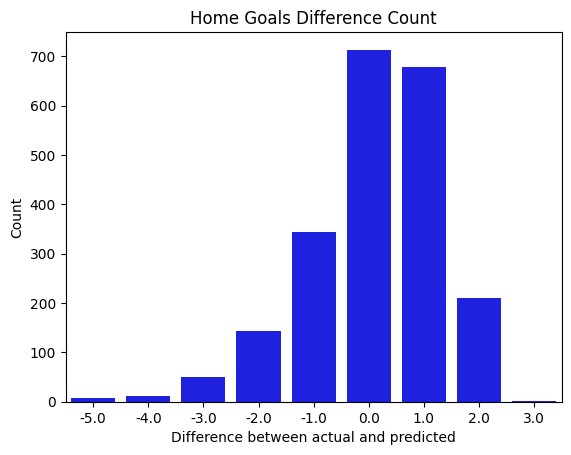

In [54]:
visualisations.histoplot(x_test, ha='Home')

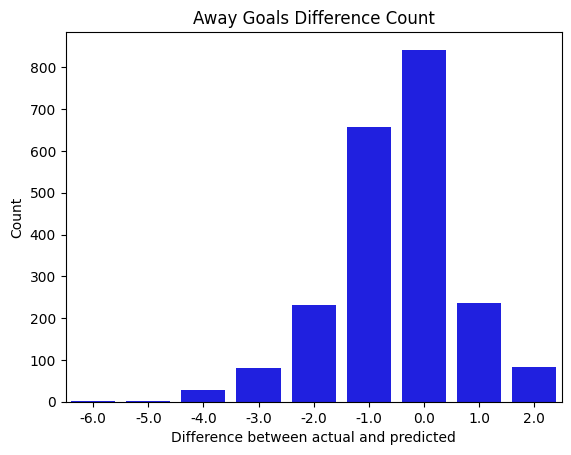

In [55]:
visualisations.histoplot(x_test, ha='Away')

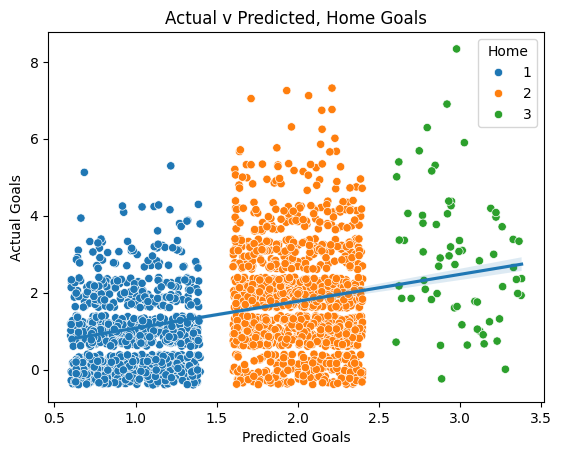

In [56]:
visualisations.actuals_predicted(x_test, ha='Home')

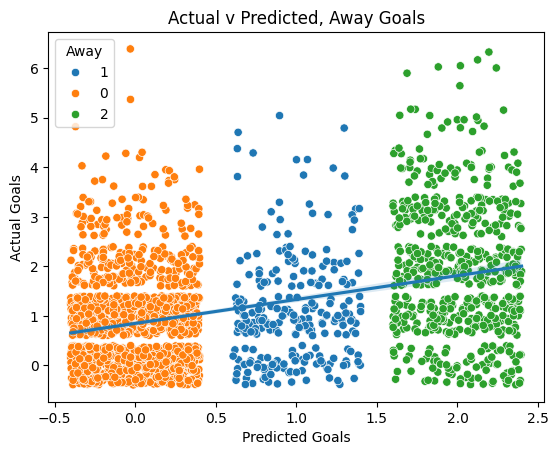

In [57]:
visualisations.actuals_predicted(x_test, ha='Away')

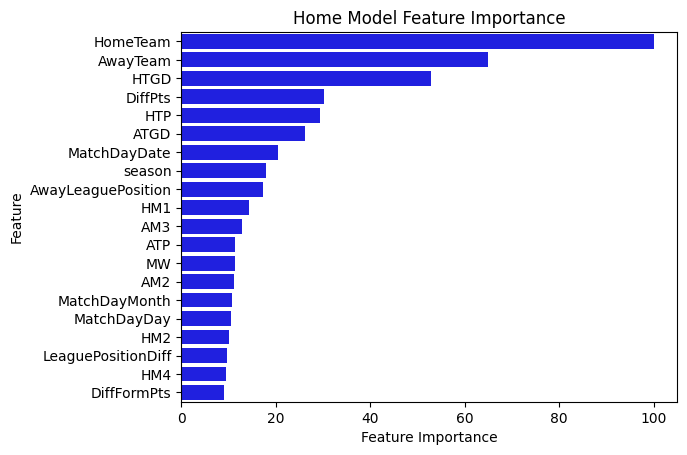

In [58]:
visualisations.plot_features(regressor_1, 'Home',n=20)

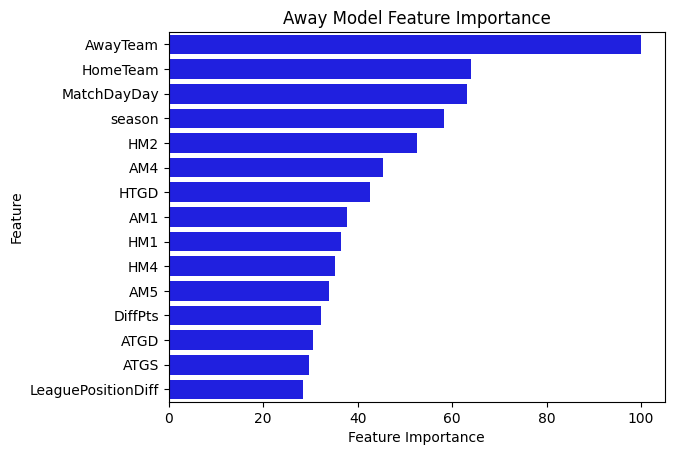

In [59]:
visualisations.plot_features(regressor_2, 'Away')